# 기존에 했던 RFM코드 사용

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import psycopg2

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D

In [122]:
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [123]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [124]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [125]:
# 데이터베이스 연결 설정
conn = psycopg2.connect(database="postgres", user="postgres", password="postgres123", host="postgres.c4brhfvhrm5g.ap-northeast-2.rds.amazonaws.com", port=5432)

In [126]:
# 빈 데이터 프레임 만들기
df_order = pd.DataFrame()
df_order_items = pd.DataFrame()
df_payments = pd.DataFrame()
df_products = pd.DataFrame()
df_customers = pd.DataFrame()
df_sellers = pd.DataFrame()
df_closed_deals = pd.DataFrame()
df_mql = pd.DataFrame()
df_geoloc = pd.DataFrame()
df_reviews = pd.DataFrame()

# DB에서 데이터를 가져와 데이터프레임으로 만들기
def make_df(df, db_table):
    cur = conn.cursor()
    query = 'SELECT * FROM ' + db_table
    cur.execute(query)
    temp = cur.fetchall()
    df = pd.DataFrame(temp, columns=[desc[0] for desc in cur.description])
    cur.close()
    return df

df_order = make_df(df_order, '"order"')
df_order_items = make_df(df_order_items, 'order_items')
df_payments = make_df(df_payments, 'payments')
df_products = make_df(df_products, 'products')
df_customers = make_df(df_customers, 'customers')
df_sellers = make_df(df_sellers, 'sellers')
df_closed_deals = make_df(df_closed_deals, 'closed_deals')
df_mql = make_df(df_mql, 'mql')
df_geoloc = make_df(df_geoloc, 'geoloc')
df_reviews = make_df(df_reviews, 'reviews')

## rfm세분화

In [127]:
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])

# df_order와 df_customers 병합
merged_df = df_order.merge(df_customers, on='customer_id', how='left')

# df_payments를 병합
merged_df = merged_df.merge(df_payments, on='order_id', how='left')

# 조건에 맞는 order_status를 가진 데이터만 추출
order_status = ["delivered", "shipped", "invoiced", "processing"]
df_sales_filtered = merged_df[merged_df["order_status"].isin(order_status)]

#  payment_value 열 이름 변경 #monetary=payment_value
merged_df.rename(columns={'payment_value': 'monetary'}, inplace=True)
df_sales_filtered.rename(columns={'payment_value': 'monetary'}, inplace=True)


C:\Users\lovel\AppData\Local\Temp\ipykernel_21140\4117679264.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [128]:
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,monetary
0,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,83165,13301,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,71798,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,66104,44559,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,24317,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [129]:
df_sales_filtered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,monetary
0,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,83165,13301,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,71798,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,66104,44559,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,24317,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [130]:
df_sales_filtered[df_sales_filtered['customer_unique_id'] ==0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,monetary
76590,96417,32755,delivered,2017-04-30 18:58:18,2017-04-30 19:10:15,2017-05-02 17:19:39,2017-05-24 17:52:26,2017-06-06,0,69029,manaus,AM,1.0,credit_card,3.0,73.84


In [131]:
# 현재 날짜 설정 (2018년 9월 1일 기준)
now = pd.Timestamp('2018-09-01')

# Recency 계산
df_sales_filtered['order_purchase_timestamp'] = pd.to_datetime(df_sales_filtered['order_purchase_timestamp'])
recency_df = df_sales_filtered.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency_df.columns = ['customer_unique_id', 'last_purchase_date']
recency_df['recency'] = (now - recency_df['last_purchase_date']).dt.days

# Monetary 계산
merged_df = df_sales_filtered.merge(df_payments, on='order_id', how='left')
monetary_df = merged_df.groupby('customer_unique_id')['monetary'].sum().reset_index()

# Frequency 계산
frequency_df = df_sales_filtered.groupby('customer_unique_id').size().reset_index(name='frequency')
frequency_df['F'] = np.where(frequency_df['frequency'] > 1, 2, 1)

# Recency, Monetary, Frequency 병합
rfm_df = recency_df.merge(monetary_df, on='customer_unique_id', how='left')
rfm_df = rfm_df.merge(frequency_df[['customer_unique_id', 'F']], on='customer_unique_id', how='left')
rfm_df.drop('last_purchase_date', axis=1, inplace=True)

# 점수 부여
r_labels = range(5, 0, -1)
m_labels = range(1, 6)
r_groups = pd.qcut(rfm_df['recency'], q=5, labels=r_labels)  # Recency는 낮은 값이 더 좋기 때문에 점수를 역으로 부여
m_groups = pd.qcut(rfm_df['monetary'], q=5, labels=m_labels)

rfm_df = rfm_df.assign(R=r_groups.values, M=m_groups.values)
rfm_df['RFM_Segment'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)
# rfm_df['RFM_Score'] = rfm_df[['R', 'F', 'M']].sum(axis=1)

# # 5개 등급으로 나누기
# rfm_df['grade'] = np.where(rfm_df['RFM_Score'] >= 11, '1_Very High',
#                            np.where((rfm_df['RFM_Score'] >= 9) & (rfm_df['RFM_Score'] < 11), '2_High',
#                            np.where((rfm_df['RFM_Score'] >= 7) & (rfm_df['RFM_Score'] < 9), '3_Medium',
#                            np.where((rfm_df['RFM_Score'] >= 5) & (rfm_df['RFM_Score'] < 7), '4_Low', '5_Very Low'))))

# rfm_df.head()


C:\Users\lovel\AppData\Local\Temp\ipykernel_21140\1994272858.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [132]:
# 가중치 설정
W_R = 5
W_F = 2
W_M = 5

# RFM_Score 계산
rfm_df['RFM_Score'] = rfm_df['R'].astype('int64') * W_R + rfm_df['F'].astype('int64') * W_F + rfm_df['M'].astype('int64') * W_M

# 5개 등급으로 나누기
rfm_df['grade'] = np.where(rfm_df['RFM_Score'] >= (W_R*5 + W_F*2 + W_M*5)*0.9, '1_Very High',
                           np.where(rfm_df['RFM_Score'] >= (W_R*5 + W_F*2 + W_M*5)*0.7, '2_High',
                           np.where(rfm_df['RFM_Score'] >= (W_R*5 + W_F*2 + W_M*5)*0.5, '3_Medium',
                           np.where(rfm_df['RFM_Score'] >= (W_R*5 + W_F*2 + W_M*5)*0.3, '4_Low', '5_Very Low'))))

rfm_df.head()


,customer_unique_id,recency,monetary,F,R,M,RFM_Segment,RFM_Score,grade
0,0,488,73.84,1,1,2,112,17,4_Low
1,1,121,211.91,1,4,4,414,42,2_High
2,2,180,123.52,1,3,3,313,32,3_Medium
3,3,79,107.31,2,5,3,523,44,2_High
4,4,238,119.20,2,3,3,323,34,3_Medium


In [133]:
rfm_df.columns

Index(['customer_unique_id', 'recency', 'monetary', 'F', 'R', 'M',
       'RFM_Segment', 'RFM_Score', 'grade'],
      dtype='object')

In [134]:
rfm_df['grade'].value_counts()

grade
3_Medium       47627
2_High         19425
4_Low          19280
1_Very High     4706
5_Very Low      3946
Name: count, dtype: int64

In [135]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94984 entries, 0 to 94983
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  94984 non-null  int64   
 1   recency             94984 non-null  int64   
 2   monetary            94984 non-null  float64 
 3   F                   94984 non-null  int32   
 4   R                   94984 non-null  category
 5   M                   94984 non-null  category
 6   RFM_Segment         94984 non-null  object  
 7   RFM_Score           94984 non-null  int64   
 8   grade               94984 non-null  object  
dtypes: category(2), float64(1), int32(1), int64(3), object(2)
memory usage: 4.9+ MB


C:\Users\lovel\AppData\Local\Temp\ipykernel_21140\1318733095.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\lovel\AppData\Local\Temp\ipykernel_21140\1318733095.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\lovel\AppData\Local\Temp\ipykernel_21140\1318733095.py:6: UserWarning:



`distplot` is

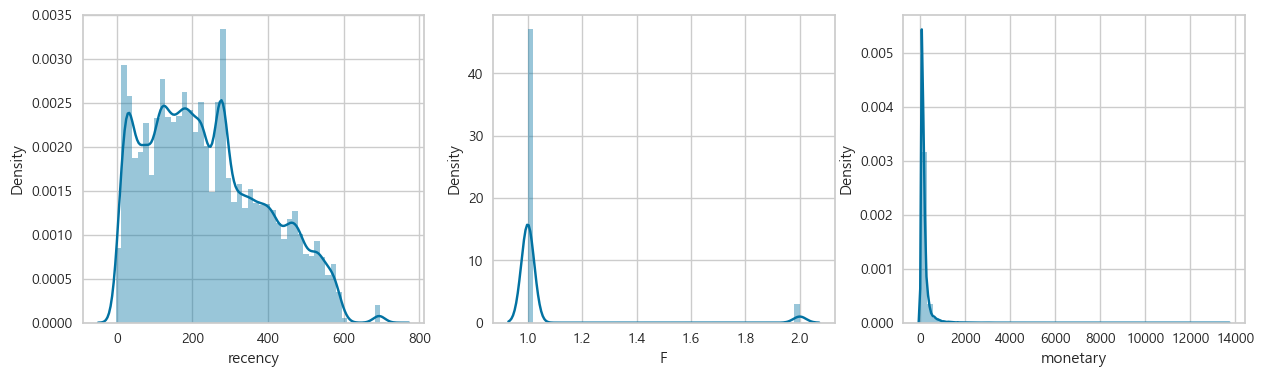

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['recency', 'F', 'monetary'], axes):
    sns.distplot(rfm_df[col], ax = ax)
    
plt.show()

In [137]:
print(rfm_df['recency'].describe())
print('---------------------------')
print(rfm_df['F'].describe())
print('---------------------------')
print(rfm_df['monetary'].describe())

count    94984.000000
mean       240.342426
std        152.999171
min         -3.000000
25%        116.000000
50%        221.000000
75%        349.000000
max        726.000000
Name: recency, dtype: float64
---------------------------
count    94984.000000
mean         1.058841
std          0.235329
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: F, dtype: float64
---------------------------
count    94984.000000
mean       173.236661
std        261.311126
min          0.000000
25%         64.010000
50%        110.630000
75%        188.340000
max      13664.080000
Name: monetary, dtype: float64


In [138]:
# # 점수 부여
# rfm_df['R_score'] = pd.qcut(rfm_df['R'], 5, labels=range(5, 0, -1)).astype(str)
# rfm_df['F_score'] = rfm_df['F'].apply(lambda x : '1' if x == 1 else '2')
# rfm_df['M_score'] = pd.qcut(rfm_df['M'], 5, labels=range(1, 6)).astype(str)


In [139]:
# # 점수부여 라벨링 결과

# print(
#         rfm_df['R_score'].value_counts(normalize=True)\
#                            .sort_index(), '\n\n',
#         rfm_df['F_score'].value_counts(normalize=True)\
#                            .sort_index(),'\n\n',
#         rfm_df['M_score'].value_counts(normalize=True)\
#                            .sort_index()
#        )

In [140]:
rfm_df.head()

,customer_unique_id,recency,monetary,F,R,M,RFM_Segment,RFM_Score,grade
0,0,488,73.84,1,1,2,112,17,4_Low
1,1,121,211.91,1,4,4,414,42,2_High
2,2,180,123.52,1,3,3,313,32,3_Medium
3,3,79,107.31,2,5,3,523,44,2_High
4,4,238,119.20,2,3,3,323,34,3_Medium


## 클러스터링

In [141]:
min_max_scaler = MinMaxScaler()

rfm_cluster = rfm_df[['recency', 'F', 'monetary']]

rfm_scaled = min_max_scaler.fit_transform(rfm_cluster)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['R', 'F', 'M'])    
rfm_scaled.head()

,R,F,M
0,0.673525,0.0,0.005404
1,0.170096,0.0,0.015509
2,0.251029,0.0,0.009040
3,0.112483,1.0,0.007853
4,0.330590,1.0,0.008724


c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.

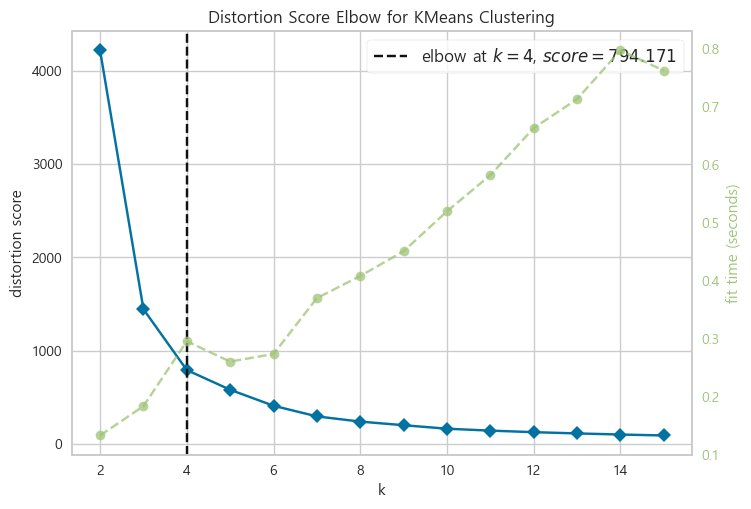

In [142]:
k = KMeans()
elbow = KElbowVisualizer(estimator = k, k = 15)
elbow.fit(rfm_scaled)
elbow.show()

plt.show()

In [143]:
# 4개 클러스터 사용 

k = KMeans(n_clusters = 4, random_state = 42)
clusters = k.fit_predict(rfm_scaled)

rfm_scaled['cluster'] = clusters
rfm_scaled

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,R,F,M,cluster
0,0.673525,0.0,0.005404,2
1,0.170096,0.0,0.015509,3
2,0.251029,0.0,0.009040,1
3,0.112483,1.0,0.007853,0
4,0.330590,1.0,0.008724,0
...,...,...,...,...
94979,0.282579,0.0,0.011658,1
94980,0.552812,0.0,0.008476,2
94981,0.150892,0.0,0.015621,3
94982,0.248285,0.0,0.012161,1


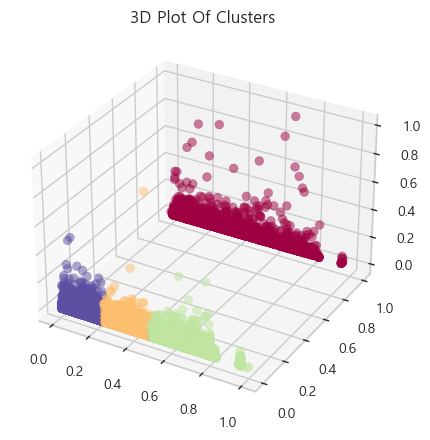

In [144]:
x = rfm_scaled['R']
y = rfm_scaled['F']
z = rfm_scaled['M']

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, s = 40, c = rfm_scaled['cluster'], marker = 'o', alpha = 0.5, cmap = 'Spectral')
ax.set_title("3D Plot Of Clusters")
plt.show()

In [145]:
rfm_df['cluster'] = rfm_scaled['cluster']
rfm_df['cluster'].value_counts().sort_index()

cluster
0     5589
1    33824
2    21172
3    34399
Name: count, dtype: int64

In [146]:
## 이 클러스터링 플랏은 어떻게 해석해야하는지 ....초록색만 동떨어져있는데 괜찮은건가요? 

# 세그먼트 분석

## 주별 고객 수

In [147]:
rfm_customer = pd.merge(rfm_df, df_customers, on='customer_unique_id', how='left')
rfm_state = rfm_customer.groupby(['grade', 'customer_state']).size().reset_index(name='Counts')
rfm_state

,grade,customer_state,Counts
0,1_Very High,AC,7
1,1_Very High,AL,24
2,1_Very High,AM,7
3,1_Very High,AP,1
4,1_Very High,BA,248
...,...,...,...
129,5_Very Low,RS,232
130,5_Very Low,SC,153
131,5_Very Low,SE,12
132,5_Very Low,SP,1811


In [169]:
fig = px.bar(rfm_state, 
             x='customer_state', 
             y='Counts', 
             color='grade',
             title='주별 고객 수',
             labels={'customer_state': 'State', 'Counts': '고객 수'})
fig.show()

## 소비 카테고리 TOP5

In [149]:
rfm_order = pd.merge(rfm_df, df_order, left_on='customer_unique_id', right_on='customer_id', how='left')
rfm_order_items = pd.merge(rfm_order, df_order_items, on='order_id', how='left')
rfm_category = pd.merge(rfm_order_items, df_products, on='product_id', how='left')

rfm_category= rfm_category.groupby(['grade', 'product_category_name']).size().reset_index(name='Counts')
top5_categories = rfm_category.groupby('grade').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)
top5_categories


,grade,product_category_name,Counts
0,1_Very High,bed_bath_table,525
1,1_Very High,health_beauty,485
2,1_Very High,sports_leisure,403
3,1_Very High,furniture_decor,384
4,1_Very High,computers_accessories,365
5,2_High,bed_bath_table,2127
6,2_High,health_beauty,1848
7,2_High,sports_leisure,1729
8,2_High,furniture_decor,1652
9,2_High,computers_accessories,1566


In [170]:
fig = px.bar(top5_categories, 
             x='product_category_name', 
             y='Counts', 
             color='grade',
             title='세그먼트 별 많이 지출한 TOP5 카테고리',
             labels={'product_category_name': 'Product Category', 'Counts': '구매 수(count)'})
fig.show()

In [151]:
# 많이 구매한 카테고리는 rfm그룹 모두 bed_bath_table > health_beauty > sports_leisure > furniture_decor > computers_accessories  순으로 나옴....

In [152]:
## rfm 등급별 결제수단

In [153]:
rfm_payment = pd.merge(rfm_order, df_payments, on='order_id', how='left')
rfm_payment = rfm_payment.groupby(['grade', 'payment_type']).size().reset_index(name='Counts')
rfm_payment


,grade,payment_type,Counts
0,1_Very High,boleto,933
1,1_Very High,credit_card,3654
2,1_Very High,debit_card,54
3,1_Very High,voucher,287
4,2_High,boleto,3915
5,2_High,credit_card,14985
6,2_High,debit_card,289
7,2_High,not_defined,2
8,2_High,voucher,1076
9,3_Medium,boleto,9469


In [171]:
fig = px.bar(rfm_payment, 
             x='payment_type', 
             y='Counts', 
             color='grade',
             title='세그먼트 별 결제 방식',
             labels={'payment_type': 'Payment Type', 'Counts': '사용 수(count)'})
fig.show()

In [155]:
# 결제수단은 rfm그룹 모두 credit_card > boleto > voucher > debit_card > not_defined  순으로 나옴....

## 주문상태

In [164]:
rfm_order = pd.merge(rfm_df, df_order, left_on='customer_unique_id', right_on='customer_id', how='inner')

order_status_counts = rfm_order.groupby(['grade', 'order_status']).size().reset_index(name='Counts')

fig = px.bar(order_status_counts, 
             x='order_status', 
             y='Counts', 
             color='grade',
             title='세그먼트 별 주문상태',
             labels={'order_status': '주문 상태', 'Counts': '주문 수'})
fig.show()


In [157]:
order_status_counts

,grade,order_status,Counts
0,1_Very High,canceled,29
1,1_Very High,delivered,4564
2,1_Very High,invoiced,14
3,1_Very High,processing,14
4,1_Very High,shipped,52
5,1_Very High,unavailable,33
6,2_High,canceled,127
7,2_High,delivered,18859
8,2_High,invoiced,48
9,2_High,processing,58


## 지출액의 평균과 총합

In [158]:
merged_payments = pd.merge(rfm_df, df_payments, left_on='customer_unique_id', right_on='order_id', how='inner')

# sum과 mean 함께 계산
avg_payment = merged_payments.groupby('grade').agg({
    'monetary': ['sum', 'mean']
}).reset_index()

# 열 이름 변경
avg_payment.columns = ['grade', 'total_monetary', 'average_monetary']


In [165]:
# 시각화
fig = go.Figure()

# 총 결제 금액 바 그래프 추가
fig.add_trace(go.Bar(
    x=avg_payment['grade'],
    y=avg_payment['total_monetary'],
    name='총 지출액',
    marker_color='indianred',
    yaxis='y1'
))

# 평균 결제 금액 꺾은선 그래프 추가
fig.add_trace(go.Scatter(
    x=avg_payment['grade'],
    y=avg_payment['average_monetary'],
    name='평균 지출액',
    mode='lines+markers',
    line=dict(color='blue'),
    marker=dict(color='lightsalmon', size=10),
    yaxis='y2'
))

# 레이아웃 설정
fig.update_layout(
    title='세그먼트 별 Monetray의 총 금액(sum)과 평균 금액(Average)',
    xaxis_title='Segment',
    yaxis=dict(title='총 지출액', anchor="x", side="left", position=0.00),
    yaxis2=dict(title='평균 지출액', anchor="x", overlaying="y", side="right")
)

fig.show()

In [160]:
# 각 세그먼트 별 고객 수 계산
customer_counts = rfm_df.groupby('grade').size().reset_index(name='customer_cnt')

# 주어진 데이터프레임에 각 세그먼트별 고객 수 추가
data = {
    'grade': ['1_Very High', '2_High', '3_Medium', '4_Low', '5_Very Low'],
    'total_monetary': [2334793.18, 5435057.25, 7873690.82, 1353965.02, 166103.75],
    'average_monetary': [470.629546, 269.195505, 158.382934, 67.121010, 40.121679]
}

df = pd.DataFrame(data)

# customer_counts와 df를 merge하여 customer_cnt 컬럼 추가
avg_payment = pd.merge(df, customer_counts, on='grade', how='left')

avg_payment


,grade,total_monetary,average_monetary,customer_cnt
0,1_Very High,2334793.18,470.629546,4706
1,2_High,5435057.25,269.195505,19425
2,3_Medium,7873690.82,158.382934,47627
3,4_Low,1353965.02,67.121010,19280
4,5_Very Low,166103.75,40.121679,3946


In [161]:
# 고객 세그먼트 별 평균 지출과 총 지출

# 1_Very High 등급: 평균 지출이 가장 높음
# 총 지출도 높긴 하지만, 2_High나 3_Medium 등급에 비해 낮음
# => 1등급 고객 수가 상대적으로 적어서 그런 것 같음
# 이 고객들은 기업에게 가장 가치 있는 고객으로 볼 수 있으므로, 이들을 유지하고 추가적인 이익을 얻기 위한 마케팅 전략 필요

# 2_High 등급: 평균 지출은 1_Very High 등급에 비해 낮지만, 총 지출은 1_Very High 등급보다 높음
# 이는 이 세그먼트에 속하는 고객 수가 많을 수 있음을 의미=> 이 세그먼트의 지출을 더 높이기 위한 전략 필요

# 3_Medium 등급: 총 지출이 가장 높지만, 평균 지출은 1_Very High와 2_High 등급에 비해 낮음
# 이는 이 세그먼트에 속하는 고객 수가 많을 수 있음을 의미 => 더 높은 등급으로 유도하기 위한 전략

# 4_Low , 5_Very Low 등급: 평균 지출과 총 지출 모두 낮음
# 더 높은 등급으로 이동시키기 위한 전략이 필요

# 기회의 규모 관점: 
# 총 지출에서 3_Medium 등급이 가장 높은 비중을 차지한다. 따라서 이 그룹의 고객들을 더 높은 등급으로 이동시키기 위한 전략을 세우면 큰 기회를 얻을 수 있음 

## 평균 배송 시간

In [168]:
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_delivered_customer_date'] = pd.to_datetime(merged_df['order_delivered_customer_date'])
merged_df['Delivery_Time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days

# rfm_df와 merged_df 병합
merged_rfm = pd.merge(merged_df, rfm_df[['customer_unique_id', 'grade']], on='customer_unique_id', how='left')

# 각 클래스별로 평균 배송 시간 계산
avg_delivery_time = merged_rfm.groupby('grade')['Delivery_Time'].mean().reset_index()

# 시각화
fig = px.bar(avg_delivery_time, 
             x='grade', 
             y='Delivery_Time', 
             title='세그먼트 별 평균 배송 시간(Days)',
             labels={'grade': 'Segment', 'Delivery_Time': '평균 배송 시간 (Days)'})
fig.show()


## 재구매율

In [173]:
# 고객별 주문 횟수 계산
customer_orders = merged_rfm.groupby(['customer_unique_id']).size().reset_index(name='order_count')

# rfm_df와 customer_orders 병합
rfm_with_orders = pd.merge(rfm_df, customer_orders, on='customer_unique_id', how='left')

# 각 세그먼트별 재구매한 고객의 수 계산
repurchase_counts = rfm_with_orders[rfm_with_orders['order_count'] > 1].groupby('grade').size().reset_index(name='repurchase_count')

# 각 세그먼트별 전체 고객의 수 계산
total_counts = rfm_with_orders.groupby('grade').size().reset_index(name='total_count')

# 두 데이터프레임 병합
repurchase_rate_df = pd.merge(total_counts, repurchase_counts, on='grade', how='left')

# 재구매율 계산
repurchase_rate_df['repurchase_rate'] = repurchase_rate_df['repurchase_count'] / repurchase_rate_df['total_count'] * 100

repurchase_rate_df[['grade', 'repurchase_rate']]


,grade,repurchase_rate
0,1_Very High,31.342966
1,2_High,10.682111
2,3_Medium,3.426628
3,4_Low,1.991701
4,5_Very Low,0.582869


In [175]:
fig = px.bar(repurchase_rate_df, 
             x='grade', 
             y='repurchase_rate', 
             title='세그먼트별 재구매율',
             labels={'grade': '세그먼트', 'repurchase_rate': '재구매율 (%)'},
             color='grade', 
             height=400)

fig.update_layout(showlegend=False)  # 범례가 필요없을 경우
fig.update_yaxes(tickformat=".2f")   # Y축 값을 소수점 두 자리로 제한
fig.show()